In [1]:
import numpy as np
import pandas as pd
import io
import urllib.request

from matplotlib import pylab as plt
from sklearn.utils import resample

# Настройки matplotlib

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 16

## Блок часто используемых функций:
*Описание:* Здесь объявлены часто вызываемые функции, которые я часто использую в этом ноутбуке

In [2]:
def load_data(url, name):
    """
    Loading data

    Parameters
    ----------
    url : string
        url leading to data
    name : string
        name by which data will be stored in memory

    Returns
    -------
    DataFrame
        dataframe with loaded data
    """
    try:
        urllib.request.urlretrieve(url, name)
    except PermissionError:
        print('Data is already loaded')
    df = pd.read_csv(name)
    return df

def calc_w(x, y):
    """
    Calculate weights

    Parameters
    ----------
    X : numpy array
        matrix resulted from independent vector 
    y : numpy array
        vector of dependent values

    Returns
    -------
    numpy array
        numpy array with calculated weights
    """
    return np.dot(np.linalg.pinv(x), y)

def _plot(x, y, y_pred = None, title = None, 
          plot_label = None, x_label = 'Время', y_label = 'Цена'):
    """
    Plots data and predicted function line if there is one (Captain, where is m boat?)

    Parameters
    ----------
    x : numpy array
        features
    y : numpy array
        vector of dependent values
    y_pred : numpy array
        vector of predicted values
    title : string
        plot name
    plot_label : string
        name of the line that will be shown in legend
    x_label : string
    y_label : string

    Returns
    -------
    None
    """    
    plt.scatter(x, y, label='', s = 10)
    
    if y_pred is not None:
        y_pred_std = [0,0]
        plt.plot(x, y_pred, color='black', linewidth=2, label=plot_label)
        for i in range(2,len(y_pred)-2):
            y_pred_std.append(np.std(y_pred[i-2:i+2]))
        y_pred_std.append(0)
        y_pred_std.append(0)
        plt.fill_between(x,y_pred - y_pred_std, y_pred + y_pred_std, label='Prediction')
        plt.legend()
        
    if title:
        plt.title(title, size = 26)
        
    plt.xlabel(x_label, size=16)
    plt.ylabel(y_label, size=16)
    plt.grid()
    plt.show()

## Цель вычислительного эксперимента

Необходимо решить задачу регрессии с использованием криволинейной регрессии. Для этого предлагается:  
 - Написать процедуру bootstrep, которая возвращает К выборок того же объема, что и обучающая,    
 - Для каждой выборки настроить параметры, вычислить ожидание параметров, дисперсию и ковариацию параметров, ожидание ошибки, дисперсию ошибки.  
 - (Дополнительно) для фиксированного числа признаков построить график зависимости ожидания и дисперсии ошибки от объема выборки.  
  
**Метрика качества:** MSE - Mean Square Error, R2 - coefficient of determination

## Описание выборок
В эксперименте решается задача регрессии для предсказания цены на белый хлеб, использован датасет WhiteBreadPrices  
 (ссылка на датасет: https://sourceforge.net/p/mvr/code/HEAD/tree/data/WhiteBreadPrices.csv?format=raw)
 
Данный датасет содержит всего две колонки и не требует серьёзной предобработки, поэтому идеально подходит для демонстрации метода bootstrap 

## Задача: Предсказание цены на хлеб  
  
*Описание задачи*: В этой задаче мы будем предсказывать цену на порезанный хлеб в зависимости от времени.  

#### Шаг 0: Загрузка и визуализация выборки

In [3]:
url = 'https://sourceforge.net/p/mvr/code/HEAD/tree/data/WhiteBreadPrices.csv?format=raw'
name = 'WhiteBreadPrices.csv'
df = load_data(url, name)
df.head()

,0.27723,0
0,0.29703,0.005155
1,0.21782,0.010309
2,0.12871,0.015464
3,0.31683,0.020619
4,0.34653,0.025773


Видим, что у датасета нет названий столбцов. Непорядок! Заглянем на сайт-источник и обнаружим, что именно имелось ввиду:  
>'The 1st column is the price of a loaf of bread;'  
>'the 2nd column is the time.'  

Изменим название столбцов в соответствии с полученной информацией

In [4]:
df.columns = ["Price", "Time"]
df.head()

,Price,Time
0,0.29703,0.005155
1,0.21782,0.010309
2,0.12871,0.015464
3,0.31683,0.020619
4,0.34653,0.025773


Выведем информацию о датасете:

In [5]:
print("Dataset has:")
print("  %s rows, %s feature" % (df.shape[0], int(df.shape[1] - 1)))
print("  %s unique feature values" % len(df['Time'].unique()))
print("\nIs there any Nan or missing values?")
print(df.isna().sum())

Dataset has:
  194 rows, 1 feature
  194 unique feature values

Is there any Nan or missing values?
Price    0
Time     0
dtype: int64


Всё в порядке. Можем приступать к визуализации данных

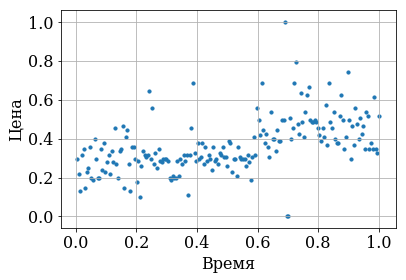

In [6]:
x = df.iloc[:, 1]
y = df.iloc[:, 0]
_plot(x, y)

#### Шаг 1: Реализация метода Bootstrap для сэмплирования выборки

Разобъём выборку на train и test с перемешиванием:

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Для простоты работы процедуры botstrap вновь объеденим X_train и y_train в один pandas.DataFrame

In [8]:
df_train = pd.concat([X_train, Y_train], axis=1, sort=False)

Напишем процедуру bootstrap, которая возвращает К выборок того же объема, что и обучающая

In [9]:
def bootstrap(df, K):
    """
    Creates K samples of pairs <X,Y> with size len(X)

    Parameters
    ----------
    df : pandas.DataFrame
        feature matrix
    K : int
        number of samples
    Returns
    -------
    samples: list
        list of pandas.Dataframes (samples) with length = K
    """
    return [df.sample(n=df.shape[0], replace=True) for _ in range(K)]

И построим 10 выборок

In [10]:
sample_list = bootstrap(df_train, 10)

Для каждой выборки настроим параметры

In [11]:
from tqdm.notebook import tqdm

weights_list = []
error_list = []

# a little bit of feature engineereing for better accuracy
x_test = np.column_stack((np.ones(X_test.values.shape[0]), X_test.values, X_test.values*np.sin(10*X_test.values)))
y_test = Y_test.values

for K,sample in enumerate(tqdm(sample_list)):
    x_train = sample['Time'].values
    y_train = sample['Price'].values
    
    x_train = np.column_stack((np.ones(x_train.shape[0]), x_train, x_train*np.sin(10*x_train)))
    
    # calculate weights
    w = calc_w(x_train, y_train)
    
    # predict independent vector for sample
    y_pred = x_test@w
    
    # calculate residual
    delta_y = y_test - y_pred
    
    # calculate errors
    mse_value = np.mean(delta_y**2)
    print('K{}, MSE: {:0.5f}'.format(K, mse_value))
    
    #add calculated weights and errors to corresponding arrays
    weights_list.append(w)
    error_list.append(mse_value)
    
    

K0, MSE: 0.00887
K1, MSE: 0.00917
K2, MSE: 0.00891
K3, MSE: 0.00865
K4, MSE: 0.00875
K5, MSE: 0.00878
K6, MSE: 0.00905
K7, MSE: 0.00872
K8, MSE: 0.00864
K9, MSE: 0.00910



Вычислим матожидание параметров, дисперсию и ковариацию параметров 

In [12]:
print(f'Матожидание параметров {np.mean(weights_list, axis = 0)}')
print(f'Дисперсия параметров   {np.var(weights_list, axis = 0)}')

pd.DataFrame(np.cov(weights_list, rowvar=False), index=['w1','w2','w3'], columns=['w1','w2','w3'] )

Матожидание параметров [0.24930651 0.21322169 0.09592032]
Дисперсия параметров   [0.00017052 0.0008546  0.00045248]


,w1,w2,w3
w1,0.000189,-0.000366,0.000069
w2,-0.000366,0.000950,0.000062
w3,0.000069,0.000062,0.000503


Вычислим матожидание ошибки и дисперсию ошибки

In [13]:
print('Матожидание {:0.6f}'.format(np.mean(error_list, axis = 0)))
print(f'Дисперсия   {np.var(error_list, axis = 0)}')

Матожидание 0.008865
Дисперсия   3.258364767448459e-08


10% выборки, MSE: 0.013, дисперсия MSE: 0.000640
15% выборки, MSE: 0.010, дисперсия MSE: 0.000432
20% выборки, MSE: 0.009, дисперсия MSE: 0.000358
25% выборки, MSE: 0.009, дисперсия MSE: 0.000332
30% выборки, MSE: 0.009, дисперсия MSE: 0.000281
35% выборки, MSE: 0.009, дисперсия MSE: 0.000248
40% выборки, MSE: 0.010, дисперсия MSE: 0.000254
45% выборки, MSE: 0.010, дисперсия MSE: 0.000264
50% выборки, MSE: 0.010, дисперсия MSE: 0.000283
55% выборки, MSE: 0.010, дисперсия MSE: 0.000287
60% выборки, MSE: 0.009, дисперсия MSE: 0.000299
65% выборки, MSE: 0.009, дисперсия MSE: 0.000301
70% выборки, MSE: 0.009, дисперсия MSE: 0.000304
75% выборки, MSE: 0.009, дисперсия MSE: 0.000305
80% выборки, MSE: 0.009, дисперсия MSE: 0.000318
85% выборки, MSE: 0.009, дисперсия MSE: 0.000299
90% выборки, MSE: 0.009, дисперсия MSE: 0.000305
95% выборки, MSE: 0.009, дисперсия MSE: 0.000283
100% выборки, MSE: 0.009, дисперсия MSE: 0.000287



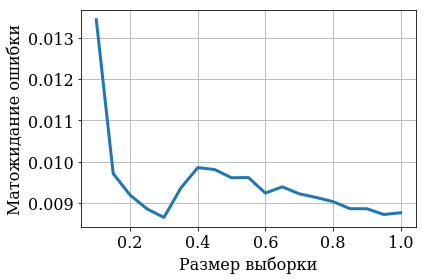

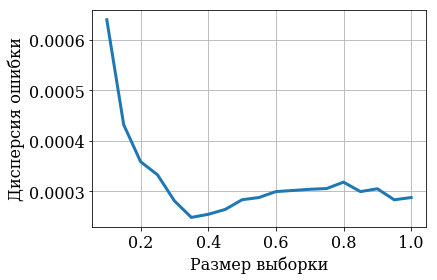

In [14]:
sample_length_list = np.arange(0.1, 1.05, 0.05)
error_list = []
error_vars = []

for length in tqdm(sample_length_list):
    x_train = X_train.values[:int(len(X_train)*length)]
    y_train = Y_train.values[:int(len(Y_train)*length)]
    
    # a little bit of feature engineereing for better accuracy
    x_train = np.column_stack((np.ones(x_train.shape[0]), x_train, x_train*np.sin(10*x_train)))
    
    # calculate weights
    w = calc_w(x_train, y_train)
    
    # predict independent vector for sample
    y_pred = x_test@w
    
    # calculate residual
    delta_y = y_test - y_pred
    
    # calculate errors
    mse_value = np.mean(delta_y**2)
    mse_variance = np.mean((delta_y)**4 - mse_value**2)
    print('{}% выборки, MSE: {:0.3f}, дисперсия MSE: {:0.6f}'.format(int(length*100),
                                                           mse_value,
                                                           mse_variance))
    
    #add calculated errors and variances to corresponding arrays
    error_list.append(mse_value)
    error_vars.append(mse_variance)

plt.xlabel('Размер выборки')
plt.ylabel('Матожидание ошибки')
plt.plot(sample_length_list, error_list)
plt.grid()
plt.show()

plt.xlabel('Размер выборки')
plt.ylabel('Дисперсия ошибки')
plt.plot(sample_length_list, error_vars)
plt.grid()
plt.show()


Исходя из графиков мы видим, что при увеличении размера выборки как матожидание, так и дисперсия ошибки убывает (что несколько неожиданно).